In [1]:
%matplotlib inline

In [2]:
from __future__ import division, print_function
from itertools import count, islice, product, filterfalse
from more_itertools import take
from random import shuffle, randrange
import matplotlib.pyplot as plt
import numpy as np
import z3

import permutations
from time_it import time_it

In [3]:
def fract(x, y, k, n, o, z):
    if k == 0:
        return []
    n2 = n // 2
    k2 = k // 2
    return (
        fract(x, y, k - 1, n2, o, z + 1) +
        fract(x, y, k - 1, n2, o + n2, z + 1) +
        [z3.Distinct(*[x[i] >> z for i in range(o, o + n)]),
         z3.Distinct(*[y[i] >> z for i in range(o, o + n)])] +
        ([z3.Distinct(*[
            ((x[i] >> (z + k - k2)) << k2) + (y[i] >> (z + k - k2))
            for i in range(o, o + n)])]
            if k % 2 == 0 else []))

In [4]:
def fractz3(k, use_hammersley=False, seed=-1):
    if k == 0:
        return
    n = 2 ** k
    x = [z3.BitVec('x__{}'.format(i), k) for i in range(n)]
    y = [z3.BitVec('y__{}'.format(i), k) for i in range(n)]
    cond = fract(x, y, k, n, 0, 0)

    # Fix x to be hammersley or have z3 figure an x for us
    if use_hammersley:
        hamm = permutations.hammersley(k)
        cond.extend([x[i] == hamm[i] for i in range(n)])

    if seed >= 0:
        z3.set_param('auto_config', False)
        z3.set_param('smt.phase_selection', 5)
        z3.set_param('smt.random_seed', seed)

    # Solve
    print('Solving fractz3({}): {} conditions, hold tight..'.format(k, len(cond)))
    s = z3.Solver()
    s.set(auto_config=False, mbqi=False)
    s.push()  # The above `z3.set_param`s don't work without this push
    s.add(*cond)
    print(s.check())
    m = s.model()
    xx = [m.evaluate(m[i]).as_long() for i in x]
    yy = [m.evaluate(m[i]).as_long() for i in y]
    print('x: {}'.format(xx))
    print('y: {}'.format(yy))
    print('is_fractal(x): {}'.format(permutations.is_fractal(xx)))
    print('is_fractal(y): {}'.format(permutations.is_fractal(yy)))
    print('is_perfect(x, y): {}'.format(permutations.is_perfect(k, xx, yy)))

In [5]:
time_it(fractz3, 2)

Solving fractz3(2): 7 conditions, hold tight..
sat
x: [0, 2, 1, 3]
y: [3, 0, 1, 2]
is_fractal(x): True
is_fractal(y): True
is_perfect(x, y): True


(None, 0.015120127000000094)

In [6]:
time_it(fractz3, 3)

Solving fractz3(3): 16 conditions, hold tight..
sat
x: [5, 3, 1, 6, 4, 0, 7, 2]
y: [6, 2, 4, 1, 0, 7, 5, 3]
is_fractal(x): True
is_fractal(y): True
is_perfect(x, y): True


(None, 0.018121915999999905)

In [7]:
time_it(fractz3, 6)

Solving fractz3(6): 147 conditions, hold tight..
sat
x: [44, 8, 18, 56, 24, 54, 5, 32, 31, 63, 40, 14, 0, 37, 21, 51, 38, 10, 16, 53, 27, 61, 6, 47, 29, 49, 12, 34, 2, 42, 22, 58, 17, 46, 11, 50, 39, 25, 1, 62, 55, 4, 43, 23, 15, 59, 35, 28, 48, 26, 13, 41, 60, 3, 19, 33, 36, 9, 52, 30, 57, 7, 45, 20]
y: [5, 39, 22, 61, 51, 12, 25, 43, 34, 31, 59, 0, 54, 17, 9, 46, 62, 29, 40, 7, 14, 52, 32, 21, 26, 37, 49, 10, 2, 44, 57, 18, 3, 36, 58, 30, 48, 16, 41, 15, 53, 11, 27, 33, 23, 47, 4, 60, 20, 42, 13, 55, 1, 56, 28, 38, 24, 45, 63, 6, 35, 19, 8, 50]
is_fractal(x): True
is_fractal(y): True
is_perfect(x, y): True


(None, 0.29935910900000007)

In [8]:
time_it(fractz3, 6, use_hammersley=True)

Solving fractz3(6): 211 conditions, hold tight..
sat
x: [0, 32, 16, 48, 8, 40, 24, 56, 4, 36, 20, 52, 12, 44, 28, 60, 2, 34, 18, 50, 10, 42, 26, 58, 6, 38, 22, 54, 14, 46, 30, 62, 1, 33, 17, 49, 9, 41, 25, 57, 5, 37, 21, 53, 13, 45, 29, 61, 3, 35, 19, 51, 11, 43, 27, 59, 7, 39, 23, 55, 15, 47, 31, 63]
y: [53, 13, 20, 45, 33, 27, 1, 57, 31, 36, 49, 10, 5, 60, 41, 19, 34, 29, 8, 50, 62, 6, 22, 42, 2, 54, 38, 17, 25, 46, 59, 15, 58, 21, 3, 39, 47, 9, 26, 51, 18, 63, 43, 7, 14, 35, 55, 30, 44, 4, 24, 56, 52, 23, 11, 37, 12, 40, 61, 28, 16, 48, 32, 0]
is_fractal(x): True
is_fractal(y): True
is_perfect(x, y): True


(None, 0.11964763499999997)

In [9]:
K = 8
N = 2 ** K

f8xs = [0, 128, 64, 192, 32, 160, 96, 224, 16, 144, 80, 208, 48, 176, 112, 240, 8, 136, 72, 200, 40, 168, 104, 232, 24, 152, 88, 216, 56, 184, 120, 248, 4, 132, 68, 196, 36, 164, 100, 228, 20, 148, 84, 212, 52, 180, 116, 244, 12, 140, 76, 204, 44, 172, 108, 236, 28, 156, 92, 220, 60, 188, 124, 252, 2, 130, 66, 194, 34, 162, 98, 226, 18, 146, 82, 210, 50, 178, 114, 242, 10, 138, 74, 202, 42, 170, 106, 234, 26, 154, 90, 218, 58, 186, 122, 250, 6, 134, 70, 198, 38, 166, 102, 230, 22, 150, 86, 214, 54, 182, 118, 246, 14, 142, 78, 206, 46, 174, 110, 238, 30, 158, 94, 222, 62, 190, 126, 254, 1, 129, 65, 193, 33, 161, 97, 225, 17, 145, 81, 209, 49, 177, 113, 241, 9, 137, 73, 201, 41, 169, 105, 233, 25, 153, 89, 217, 57, 185, 121, 249, 5, 133, 69, 197, 37, 165, 101, 229, 21, 149, 85, 213, 53, 181, 117, 245, 13, 141, 77, 205, 45, 173, 109, 237, 29, 157, 93, 221, 61, 189, 125, 253, 3, 131, 67, 195, 35, 163, 99, 227, 19, 147, 83, 211, 51, 179, 115, 243, 11, 139, 75, 203, 43, 171, 107, 235, 27, 155, 91, 219, 59, 187, 123, 251, 7, 135, 71, 199, 39, 167, 103, 231, 23, 151, 87, 215, 55, 183, 119, 247, 15, 143, 79, 207, 47, 175, 111, 239, 31, 159, 95, 223, 63, 191, 127, 255]
f8ys = [21, 142, 250, 91, 106, 223, 172, 44, 201, 124, 12, 158, 188, 51, 66, 233, 225, 4, 76, 167, 130, 118, 38, 215, 100, 180, 195, 31, 60, 247, 151, 84, 137, 70, 52, 198, 8, 168, 238, 111, 83, 217, 144, 41, 240, 25, 112, 176, 184, 58, 99, 230, 94, 152, 205, 19, 34, 253, 160, 120, 211, 75, 2, 135, 81, 155, 193, 17, 162, 42, 116, 237, 254, 64, 63, 186, 0, 219, 129, 109, 36, 213, 146, 96, 244, 78, 15, 179, 140, 48, 122, 228, 92, 170, 202, 29, 196, 103, 26, 132, 32, 248, 191, 69, 114, 175, 226, 55, 156, 6, 89, 209, 10, 234, 165, 72, 206, 104, 56, 138, 182, 22, 86, 221, 126, 148, 242, 47, 161, 93, 3, 246, 115, 207, 153, 54, 224, 39, 102, 128, 16, 189, 218, 74, 208, 28, 80, 178, 59, 136, 249, 127, 150, 110, 45, 192, 67, 239, 171, 14, 119, 166, 235, 43, 212, 5, 77, 157, 49, 197, 187, 105, 143, 85, 24, 252, 71, 241, 133, 11, 181, 62, 97, 200, 23, 145, 222, 88, 231, 121, 35, 173, 149, 117, 46, 210, 232, 30, 90, 169, 9, 139, 245, 73, 108, 204, 183, 50, 57, 185, 216, 123, 65, 229, 131, 1, 163, 82, 20, 251, 194, 33, 98, 154, 101, 203, 177, 53, 147, 87, 18, 243, 220, 13, 68, 174, 37, 141, 236, 113, 255, 40, 125, 159, 27, 190, 214, 95, 79, 227, 134, 7, 164, 107, 61, 199]

# The quality of the sequences generated doesn't depend much on the RNG used,
# so feel free to plug your favourite here.
# Also note that this function is the only source of nondeterminism.
# rand_bit      returns 0 or 1
def randbit():
    return randrange(2)

# Makes random swaps over the permutation xs which keep it's fractality. It
# only affects the lower K/2 bits of xs elements, so it doesn't degrade the
# discrepancy.
# The complexity of the algorithm is O(N log(N)).
def scramble(xs):
    for i in range(K//2):
        length = 2 ** (K - i)
        q = 2 ** (i + 1)
        for offs in range(0, N, length):
            inv = [0] * (N // 2)
            for j in range(offs, offs + length // 2):
                inv[xs[j] // q] = j

            for j in range(offs + length // 2, offs + length):
                if randbit():
                    j2 = inv[xs[j] // q]
                    xs[j],xs[j2] = xs[j2],xs[j]

def reverse(xs, offs, length):
    i, j = offs, offs+length-1
    while i < j:
        xs[i], xs[j] = xs[j], xs[i]
        i += 1
        j -= 1

# Makes random reverses over xs and ys. It keeps the points untouched and
# chages only their order while keeping xs and ys fractal.
# The complexity is O(N log(N)).
def reorder(xs, ys):
    length = N
    while length > 1:
        for offs in range(0, N, length):
            if randbit():
                reverse(xs, offs, length)
                reverse(ys, offs, length)
        length //= 2

def fract8_create(randomize=True):
    xs,ys = f8xs[:],f8ys[:]
    if randomize:
        scramble(xs)
        scramble(ys)
        reorder(xs, ys)
    return (
        np.array(xs) / float(N),
        np.array(ys) / float(N))

In [10]:
def radical_inverse(i, base):
    res = 0
    f = 1.0
    while i > 0:
        f = f / base
        res += f * (i % base)
        i = i // base
    return res

def halton2d_create(n):
    return (
        np.array([radical_inverse(i, 2) for i in range(n)]),
        np.array([radical_inverse(i, 3) for i in range(n)]))

<ipython-input-11-4e1c14a9cde9>:8: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal', 'datalim')


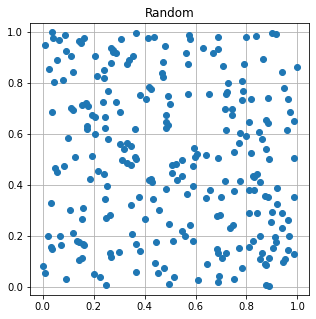

In [11]:
np.random.seed(42431)
rx, ry = np.random.rand(N), np.random.rand(N)

plt.figure(figsize=(5, 5))
plt.grid(True)
plt.plot(rx, ry, 'o')
plt.title('Random')
plt.axes().set_aspect('equal', 'datalim')
plt.show()

<ipython-input-12-2c309532aa32>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal', 'datalim')


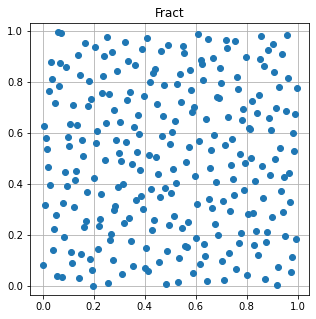

In [12]:
fx, fy = fract8_create(randomize=False)

plt.figure(figsize=(5, 5))
plt.grid(True)
plt.plot(fx, fy, 'o')
plt.title('Fract')
plt.axes().set_aspect('equal', 'datalim')
plt.show()

<ipython-input-13-ac1a8c73248d>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.axes().set_aspect('equal', 'datalim')


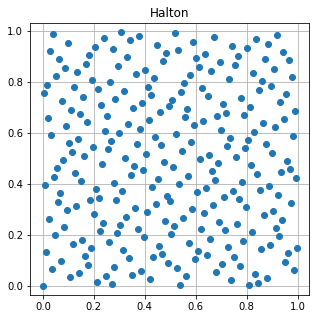

In [13]:
hx, hy = halton2d_create(N)

plt.figure(figsize=(5, 5))
plt.grid(True)
plt.plot(hx, hy, 'o')
plt.title('Halton')
plt.axes().set_aspect('equal', 'datalim')
plt.show()

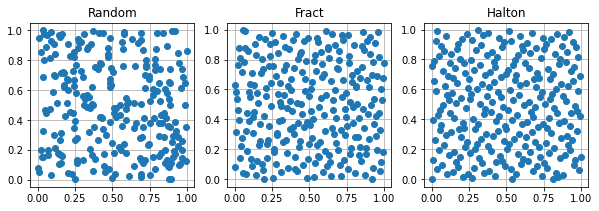

In [14]:
fig = plt.figure(figsize=(10, 10))

fig.add_subplot(1,3,1, title='Random', adjustable='box', aspect=1.0)
plt.grid()
plt.plot(rx, ry, 'o')

fig.add_subplot(1,3,2, title='Fract', adjustable='box', aspect=1.0)
plt.grid()
plt.plot(fx, fy, 'o')

fig.add_subplot(1,3,3, title='Halton', adjustable='box', aspect=1.0)
plt.grid()
plt.plot(hx, hy, 'o')

plt.show()

random:  3.0
fract:   3.109375
halton:  3.125
pi:      3.141592653589793


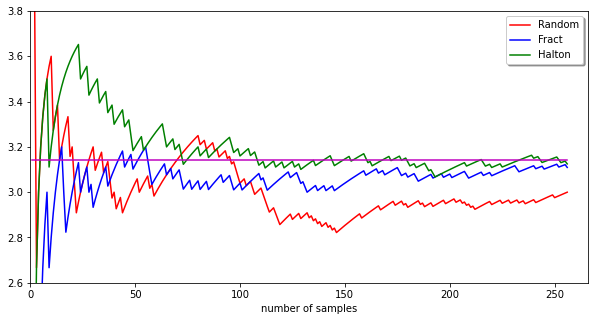

In [15]:
def pi_over_4(x, y):
    return float((x - 0.5) ** 2 + (y - 0.5) ** 2 < 0.5 ** 2)

def mc(f, n, xs, ys):
    res = []
    s = 0.0
    for i in range(n):
        s += f(xs[i], ys[i])
        res.append(s / (i + 1))
    return np.array(res)

mc_r = 4 * mc(pi_over_4, N, rx, ry)
mc_f = 4 * mc(pi_over_4, N, fx, fy)
mc_h = 4 * mc(pi_over_4, N, hx, hy)

print('random:  {}'.format(mc_r[-1]))
print('fract:   {}'.format(mc_f[-1]))
print('halton:  {}'.format(mc_h[-1]))
print('pi:      {}'.format(np.pi))

ns = np.arange(1, N + 1)
plt.figure(figsize=(10, 5))
plt.xlim([0.0, N+10])
plt.ylim([2.6, 3.8])
plt.xlabel('number of samples')
plt.plot(ns, mc_r, 'r', label='Random')
plt.plot(ns, mc_f, 'b', label='Fract')
plt.plot(ns, mc_h, 'g', label='Halton')
plt.plot(ns, np.full(N, np.pi), 'm')
plt.legend(shadow=True)
plt.show()

In [ ]:
time_it(fractz3, 10, use_hammersley=True, seed=123456)

Solving fractz3(10): 3411 conditions, hold tight..
